# <b>Fondamenti di Analisi Dati</b> - a.a. 2019/2020

### 12.1 Classificazione Maximum a Posteriori (MAP)

Abbiamo visto come costruire un classificatore che, mediante la selezione di una opportuna soglia, ci permetta di predire il sesso di un soggetto in base alla sua altezza. Vediamo adesso come implementare un classificatore Maximum a Posteriori per raggiungere lo stesso scopo. Consideriamo le variabili aleatorie $S$ rappresentante il sesso dei soggetti presenti nel dataset (può assumere i valori M o F) e $H$ rappresentante l'altezza dei soggetti. Il nostro obiettivo è scegliere il valore di $S$ più probabile sapendo che $H$ assume un dato valore $h$ (es. $h=175\ cm$). Secondo il principio MAP, sceglieremo la classe $s$ che massimizza l'espressione:

\begin{equation}
P(S=s\ |\ H=h)
\end{equation}

Ciò si scrive formalmente come segue:

\begin{equation}
s^* = \arg\max_s P(S=s\ |H=h)
\end{equation}

dove $s^*$ è la classe predetta. Dato che $S$ può assumere solo due valori, $M$ o $F$, non resta che calcolare:

\begin{equation}
P(S=M\ |\ H=h) \\
P(S=F\ |\ H=h) 
\end{equation}

e scegliere la classe per la quale la probabilità a posteriori è maggiore. Ricordiamo che secondo la regola di Bayes:

\begin{equation}
P(S\ |\ H=h) = \frac{P(H=h \ | \ S)\ P(S)}{P(H=h)}
\end{equation}

Per entrambe le probabilità $P(S=M\ |\ H=h)$ e $P(S=F\ |\ H=h)$, il termine $P(H=h)$ è identico. Dato che il nostro scopo è quello di confrontare le due quantità possiamo ometterlo. Dobbiamo dunque confrontare le seguenti quantità:

\begin{equation}
P(H=h\ |\ S=M) P(S=M) \\
P(H=h\ |\ S=F) P(S=F)
\end{equation}

In pratica, spesso si assumono probabilità a priori identiche ($P(S=M)=P(S=F)=\frac{1}{2}$). In tal caso il nostro classificatore può essere espresso così:

\begin{equation}
s^* = \begin{cases}
M &se& P(H=h\ |\ S=M) \geq P(H=h\ |\ S=F) \\
F &altrimenti &
\end{cases}
\end{equation}

Dobbiamo dunque trovare un modo per **rappresentare la verosimiglianza** $P(H\ | \ S)$ in modo da poterne calcolare i valori per ogni valore di $H$ e di $S$. Osservando che $S$ può assumere solo due valori, possiamo rappresentare due funzioni di $H$ distinte:

\begin{equation}
P(H\ |\ S=M) \\
P(H\ |\ S=F) 
\end{equation}

Secondo i principi della probabilità Bayesiana, queste due probabilità possono essere modellate sulla base delle nostre **credenze** (**assunzioni**) sui dati. In particolare, ci siamo già "convinti" in passato che $H$ si distribuisce **approssimativamente** secondo una Gaussiana. Possiamo dunque modellare le due probabilità viste con due Gaussiane:

\begin{equation}
P(H=h\ |\ S=M) = G(h; \mu_M,\sigma_M^2) \\
P(H=h\ |\ S=F) = G(h; \mu_F,\sigma_F^2)
\end{equation}

Dove $\mu_M$ e $\mu_F$ sono le medie stimate dai due campioni di altezze maschili e femminili mentre $\sigma_M^2$ e $\sigma_F^2$ sono le due varianze stimate dai campioni.

Una volta definite le due Gaussiane, il nostro classificatore diventa:

\begin{equation}
s^* = \begin{cases}
M &se& G(h; \mu_M,\sigma_M^2) \geq G(h; \mu_F,\sigma_F^2) \\
F &altrimenti &
\end{cases}
\end{equation}

Vediamo ora di tradurre tutto in termini computazionali e di implementare il nostro classificatore **MAP** con assunzione di Gaussianità delle altezze. Utilizzeremo nuovamente il dataset di pesi e altezze:

In [3]:
import pandas as pd
import numpy as np
data=pd.read_csv('height_weight.csv')
data.head()

,sex,BMI,height,weight
0,M,33.36,187.96,117.933920
1,M,26.54,177.80,83.914520
2,F,32.13,154.94,77.110640
3,M,26.62,172.72,79.378600
4,F,27.13,167.64,76.203456


Suddividiamo l'insieme in training e test set utilizzando il $25\%$ dei dati come test set e il restante $75\%$ come training set:

In [4]:
from sklearn.model_selection import train_test_split
np.random.seed(1234)
data_train, data_test = train_test_split(data, test_size=0.25)

Effettuiamo dunque il fitting di due Gaussiane sui dati delle altezze maschili e femminili:

In [5]:
from scipy.stats import norm

#la notazione sotto è una notazione compatta
#per definire una distribuzione normale e fittarla sui dati

#costruiamo due distribuzioni normali separate per i due set di dati
g_m = norm(*norm.fit(data_train[data_train['sex']=='M']['height']))
g_f = norm(*norm.fit(data_train[data_train['sex']=='F']['height']))

Plottiamo dunque le due Gaussiane considerando un range di valori $x$ comune:

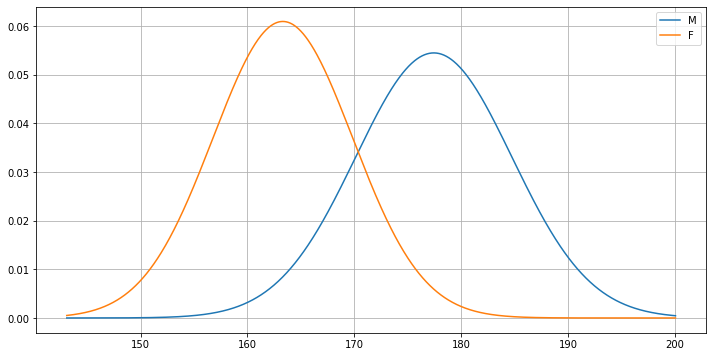

In [8]:
from matplotlib import pyplot as plt

x = np.linspace(g_f.ppf(0.001), g_m.ppf(0.999),1000)

plt.figure(figsize=(12,6))
plt.plot(x,g_m.pdf(x))
plt.plot(x,g_f.pdf(x))
plt.legend(['M','F'])
plt.grid()
plt.show()

Calcoliamo dunque le probabilità $P(H\ |\ S)$ per tutti i valori del test set:

In [9]:
prob_m = g_m.pdf(data_test['height'])
prob_f = g_f.pdf(data_test['height'])

A questo punto costruiamo un vettore `pred_male` che contenga `True` se pensiamo che il soggetto sia un uomo, e dunque se `prob_m` è maggiore di `prob_f`:

In [10]:
pred_male = prob_m>=prob_f

Calcoliamo FPR, TPR e accuracy del classificatore:

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
male_gt = data_test['sex']=='M'
acc = accuracy_score(male_gt, pred_male)
cm = confusion_matrix(male_gt, pred_male)
cm=cm/cm.sum(1).reshape(-1,1)
_, fpr, _, tpr = cm.ravel()
print("False Positive Rate: {:0.2f}".format(fpr))
print("True Positive Rate: {:0.2f}".format(tpr))
print("Accuracy: {:0.2f}".format(acc))

False Positive Rate: 0.12
True Positive Rate: 0.81
Accuracy: 0.85


Abbiamo visto come l'approccio MAP ci permetta di definire un classificatore senza la necessità di definire una soglia. In pratica, il criterio MAP identifica un punto (una soglia) nello spazio dei valori di $H$ **oltre il quale** è più conveniente predire "M" piuttosto che "F". 

Tale punto è quello in cui le due Gaussiane si intersecano e si trova (a occhio) intorno a 170cm. Per tutti i valori superiori a tale valore soglia, la Gaussiana relativa a "M" darà sempre valori maggiori di quelli della Gaussiana relativa a "F" e viceversa, al di sotto del valore soglia, la Gaussiana relativa a "F" darà valori superiori a quelli della Gaussiana relativa a "M". Se volessimo trovare il valore soglia analiticamente, dovremmo risolvere l'equazione:

\begin{equation}
G_M(x)=G_F(x)
\end{equation}

nella variabile $x$. Tale equazione si riconduce alla forma:

$ax^2 + bx + c=0$

con:

 * $a = \frac{1}{2\sigma_1^2} - \frac{1}{2\sigma_2^2}$;
 * $b = \frac{\mu_2}{\sigma_2^2} - \frac{\mu_1}{\sigma_1^2}$;
 * $c = \frac{\mu_1^2}{2 \sigma_1^2} - \frac{\mu_2^2}{2 \sigma_2^2} - \log\frac{\sigma_2}{\sigma_1}$.

Possiamo risolvere l'equazione mediante il metodo **roots** di **numpy**:

In [15]:
#Una funzione per risolvere l'equazione vista sopra
def risolvi(mu_1,mu_2,sigma_1,sigma_2):
    a = 1.0/(2*sigma_1**2) - 1.0/(2*sigma_2**2)
    b = mu_2/(sigma_2**2) - mu_1/(sigma_1**2)
    c = mu_1**2 /(2*sigma_1**2) - mu_2**2 / (2*sigma_2**2) - np.log(sigma_2/sigma_1)
    return np.roots([a,b,c])

solutions = risolvi(g_m.mean(),g_f.mean(),g_m.std(), g_f.std())
print(solutions)

[170.35818328  43.85968878]


L'equazione ha due soluzioni. La prima è il punto in cui le Gaussiane si intersecano al centro del grafico, mentre la seconda è relativa a un punto in cui le Gaussiane si interseacano a sinistra (non visibile nel grafico). Plottiamo la posizione in cui cade la prima delle due soluzioni:

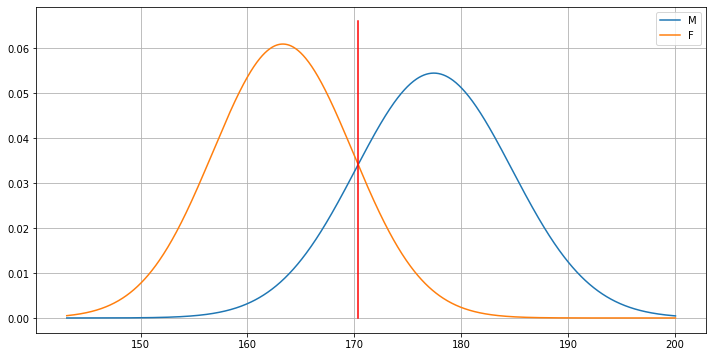

In [29]:
x = np.linspace(g_f.ppf(0.001), g_m.ppf(0.999),1000)

plt.figure(figsize=(12,6))
plt.plot(x,g_m.pdf(x))
plt.plot(x,g_f.pdf(x))
plt.legend(['M','F'])
plt.plot([solutions[0],solutions[0]],[0,0.066],'r')
plt.grid()
plt.show()

In pratica il calssificatore **MAP** è equivalente (o quasi, vista la presenza di due soluzioni) a un classificatore basato su soglia per il quale la soglia ottimale è stata determinata automaticamente. Va notato che il calssificatore MAP trovato è molto simile a un classificatore basato su soglia anche dal momento che poche altezze saranno inferiori a $50\ cm$ (il secondo punto di intersezione tra le Gaussiane).

### 12.2 Classificatore Basato su Distanza di Mahalanobis

Un altro metodo di classificazione consiste nel misurare la distanza dell'elemento $h$ da classificare rispetto alle due popolazioni alle quali esso può appartenere. Tale misura di distanza viene ottenuta mediante la **distanza di Mahalanobis**. La distanza di **Mahalanobis** tra un vettore $\mathbf x = (x_1, \ldots, x_n)^T$ multivariato e un gruppo di valori di valor medio $\mathbf \mu = (\mu_1, \ldots, \mu_n)^T$ e matrice di covarianza $\Sigma$ si definisce come:

\begin{equation}
D_M(\mathbf{x}) = \sqrt{(\mathbf{x}-\mathbf{\mu})^T \Sigma^{-1}(\mathbf{x}-\mathbf{\mu})}
\end{equation}

Considerando la matrice di covarianza, la distanza di **Mahalanobis** tiene conto della correlazione che sussiste tra le variabili del gruppo di valori considerato. 

Nel caso di un campione **monovariato** $x$ e di un gruppo di valori di media $\mu$ e varianza $\sigma^2$, la distanza di Mahalanobis resta definita come segue:

\begin{equation}
D_M(x) = \frac{x-\mu}{\sigma}
\end{equation}

Una interpretazione della distanza di Mahalanobis nel caso monovariato è che essa misura lo scostamento di un valore dalla media di un campione in termini di deviazioni standard $\sigma$. Ciò permette di pesare le distanze da campioni **più dispersi** in maniera minore rispetto alle distanze da campioni **meno dispersi**. 

Vediamo un esempio. Consideriamo due popolazioni normali di media e varianza $\mu_1=-5, \mu_2=3, \sigma_1=3, \sigma_2=1$. Consideriamo inoltre il punto $x=0$:

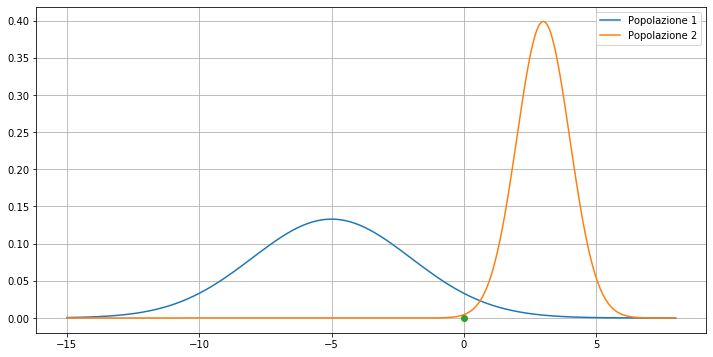

In [31]:
mu_1=-5
mu_2=3
sigma_1=3
sigma_2=1

g1 = norm(mu_1,sigma_1)
g2 = norm(mu_2,sigma_2)

x=0
plt.figure(figsize=(12,6))
dom=np.linspace(-15,8,1000)
plt.plot(dom,g1.pdf(dom))
plt.plot(dom,g2.pdf(dom))

plt.plot(x,'o')
plt.grid()
plt.legend(['Popolazione 1', 'Popolazione 2'])
plt.show()

Ci chiediamo dunque a quale popolazione appartenga il punto $x1$. Iniziamo calcolando la distanza euclidea tra il punto e le medie delle due popolazioni:

In [43]:
dist_1 = ((x-mu_1)**2)**(1/2)
dist_2 = ((x-mu_2)**2)**(1/2)

print("Distanza dalla media della prima popolazione:",dist_1)
print("Distanza dalla media della seconda popolazione:",dist_2)

Distanza dalla media della prima popolazione: 5.0
Distanza dalla media della seconda popolazione: 3.0


Il punto è più vicino alla media della seconda popolazione, il che potrebbe portarci a concludere che esso appartiene ad essa. Tuttavia, se calcoliamo le probabilità:

\begin{equation}
P(x\ |\ Popolazione = 1) = G(x;\mu_1,\sigma_1) \\
P(x\ |\ Popolazione = 2) = G(x;\mu_2,\sigma_2) 
\end{equation}

scopriamo che:

\begin{equation}
P(x\ |\ Popolazione=1) > P(x\ |\ Popolazione = 2)
\end{equation}

Vediamolo in termini computazionali:

In [33]:
print("Probabilità P(x | Popolazione = 1)=",g1.pdf(x))
print("Probabilità P(x | Popolazione = 2)=",g2.pdf(x))

Probabilità P(x | Popolazione = 1)= 0.03315904626424956
Probabilità P(x | Popolazione = 2)= 0.0044318484119380075


Dunque, per il criterio MAP, la nostra conclusione (ovvero che il punto appartiene alla seconda popolazione) è errata! Ciò nasce dall'aver ignorato il fatto che le due popolazioni hanno varianze diverse. Se invece delle distanze Euclidee calcoliamo le distanze di Mahalanobis e confrontiamo i loro valori assoluti, otteniamo:

In [34]:
mx_p1 = float(x-mu_1)/sigma_1
mx_p2 = float(x-mu_2)/sigma_2

print(abs(mx_p1),abs(mx_p2))

1.6666666666666667 3.0


Il punto è più vicino alla prima popolazione e dunque va classificato come tale!

Torniamo al caso del classificatore basato sulle altezze. Considerate le due popolazioni Gaussiane, possiamo calcolare le distanze di Mahalanobis di un dato valore $h$ rispetto alle due popolazioni. Il valore $h$ verrà classificato come appartenente alla popolazione dalla quale si è misurata una distanza (in valore assoluto) minore. Vediamolo in termini computazionali:

In [44]:
#calcoliamo le distanze per i dati di test
#utilizzando media e varianza calcoalte sul training set
dist_male = (data_test.height-g_m.mean())/g_m.std()
dist_female = (data_test.height-g_f.mean())/g_f.std()

Adesso classifichiamo come uomini tutti i casi in cui la distanza dalla popolazione degli uomini è in valore assoluto minore della distanza dalla popolazione delle donne:

In [46]:
pred_male=np.abs(dist_male)<np.abs(dist_female)

Calcoliamo l'accuracy del nuovo classificatore:

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score
acc = accuracy_score(male_gt, pred_male)
cm = confusion_matrix(male_gt, pred_male)
cm=cm/cm.sum(1).reshape(-1,1)
_, fpr, _, tpr = cm.ravel()
print("False Positive Rate: {:0.2f}".format(fpr))
print("True Positive Rate: {:0.2f}".format(tpr))
print("Accuracy: {:0.2f}".format(acc))

False Positive Rate: 0.20
True Positive Rate: 0.88
Accuracy: 0.83


### 12.3 Naive Bayes

Abbiamo visto come il principio MAP ci permette di costruire un semplice classificatore basato sull'osservazione dei valori di una variabile casuale. Spesso però può capitare che la classe di appartenenza di un determinato elemento possa dipendere dai valori di più variabili casuali. Consideriamo ad esempio le variabili aletaorie:
 
 * $S$ indica il sesso e può assumere come valori "M" o "F";
 * $H$ indica l'altezza del soggetto;
 * $W$ indica il peso del soggetto;

Se volessimo classificare i soggetti sulla base dei valori delle due variabili $H$ e $W$, per il principio MAP dovremmo trovare il valore di $S$ che massimizza la probabilità a posteriori:

\begin{equation}
P(S\ |\ H,W) = \frac{P(H,W\ |\ S)\ P(S)}{P(H,W)}
\end{equation}

Dato che vogliamo massimizzare la probabilità a posteriori, possiamo tralasciare il denominatore e scrivere:

\begin{equation}
s^* = \arg\max_s P(S = s\ |\ H,W) = \arg\max_s P(H,W\ |\ S = s) P(S = s)
\end{equation}

L'espressione da massimizzare corrisponde alla distribuzione congiunta di $H$ e $W$ dato $S$. Coinvolgendo più variabili aleatorie, questa probabilità è difficile da modellare. 

Cerchiamo dunque di "manipolare" l'espressione vista sopra per semplificare il problema. Possiamo sviluppare l'espressione come segue:

\begin{equation}
P(H,W\ |\ S) P(S) =  P(H,W,S) = P(H\ |\ W,S)\ P(W,S) = P(H\ |\ W,S)\ P(W\ |\ S)\ P(S)
\end{equation}

Un classificatore Naive Bayes fa a questo punto l'assunzione (naive per l'appunto) che le variabili $H$ e $W$ siano **condizionalmente indipendenti l'una rispetto all'altra data la classe S**, ovvero che:

\begin{equation}
H \perp\!\!\!\perp W\ |\ S
\end{equation}

Va notato che l'assunzione è **davvero Naive** in quanto assume che **una volta nota la classe di appartenenza, il valore di W non ci dice nulla sul valore di H e, viceversa, il valore di H non ci dice nulla sul valore w**. Ciò implicherebbe che, considerato l'insieme delle donne ($S$ noto), allora a un valore di $H$ ad esempio pari a $150 cm$ può corrispondere un qualsiasi valore di $W$ . In realtà sappiamo che questa condizione è spesso falsa (le variabili che rappresentano diversi aspetti di un fenomeno tendono a influenzarsi). Nonostante tale assunzione, i classificatori Naive Bayes restano uno strumento molto potente in grado di gestire con facilità un grosso numero di variabili indipendenti.

L'indipendenza condizionale tra $H$ e $W$ implica che:

\begin{equation}
P(H\ |\ W,S) = P(H\ |\ S)
\end{equation}

da cui otteniamo:

\begin{equation}
P(H,W\ |\ S) P(S) = P(H\ |\ W,S)\ P(W\ |\ S)\ P(S) = P(H\ |\ S)\ P(W\ |\ S)\ P(S)
\end{equation}

Assumendo nuovamente la distribuzione a priori sui sessi uniforme ($P(s)=0.5$), la nostra ottimizzazione diventa:

\begin{equation}
s^* = \arg\max_s P(H\ |\ S = s)\ P(W\ |\ S = s)
\end{equation}

Possiamo modellare le distribuzioni $P(H\ |\ S=s)$ e $P(W\ |\ S=s)$ con quattro Gaussiane (due per ogni variabile, una per sesso):

In [48]:
g_m_h = norm(*norm.fit(data_train[data_train['sex']=='M']['height']))
g_f_h = norm(*norm.fit(data_train[data_train['sex']=='F']['height']))
g_m_w = norm(*norm.fit(data_train[data_train['sex']=='M']['weight']))
g_f_w = norm(*norm.fit(data_train[data_train['sex']=='F']['weight']))

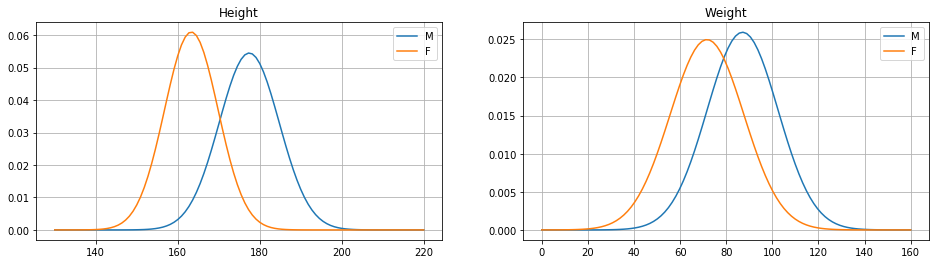

In [49]:
plt.figure(figsize=(16,4))
dom=np.linspace(130,220,100)
plt.subplot(121)
plt.plot(dom,g_m_h.pdf(dom))
plt.plot(dom,g_f_h.pdf(dom))
plt.grid()
plt.title('Height')
plt.legend(['M','F'])

dom2=np.linspace(0,160,100)
plt.subplot(122)
plt.plot(dom2,g_m_w.pdf(dom2))
plt.plot(dom2,g_f_w.pdf(dom2))
plt.grid()
plt.title('Weight')
plt.legend(['M','F'])

plt.show()

A questo punto, per ogni elemento del test set, dobbiamo calcolare le probabilità $P(H\ |\ S = s)\ P(W\ |\ S = M)$ e $P(H\ |\ S = s)\ P(W\ |\ S = F)$

In [50]:
pm = g_m_h.pdf(data_test['height'])*g_m_w.pdf(data_test['weight'])
pf = g_f_h.pdf(data_test['height'])*g_f_w.pdf(data_test['weight'])

Classifichiamo ogni elemento controllando per quali valori si ha: $P(H\ |\ S = s)\ P(W\ |\ S = M) >= P(H\ |\ S = s)\ P(W\ |\ S = F)$

In [51]:
male_pred = pm>=pf
male_pred

array([False,  True, False, ...,  True, False, False])

Calcoliamo l'accuracy del classificatore:

In [52]:
accuracy_score(male_gt,male_pred)

0.8506616257088847

**Scikit-Learn** mette a disposizione una implementazione del classificatore Naive Bayes basato su assunzione Gaussiana. Vediamo come utilizzarla:

In [53]:
from sklearn.naive_bayes import GaussianNB

#passiamo priors=[0.5, 0.5] per assumere probabilità a priori uniformi
model = GaussianNB(priors=[0.5,0.5])
#effettuiamo il fit del modello mediante il metodo fit
model.fit(data_train[['height','weight']],data_train['sex'])

GaussianNB(priors=[0.5, 0.5], var_smoothing=1e-09)

Possiamo classificare gli elementi del test set mediante il metodo `predict`:

In [54]:
model.predict(data_test[['height','weight']])

array(['F', 'M', 'F', ..., 'M', 'F', 'F'], dtype='<U1')

Possiamo calcolare l'accuracy del classificatore direttamente mediante il metodo `score`:

In [55]:
model.score(data_test[['height','weight']],data_test['sex'])

0.8506616257088847

Proviamo adesso ad allenare il classificatore Naive Bayes utilizzando anche la variabile BMI:

In [56]:
model = GaussianNB(priors=[0.5,0.5])
model.fit(data_train[['height','weight','BMI']],data_train['sex'])
model.score(data_test[['height','weight','BMI']],data_test['sex'])

0.8572778827977315

### Implementazione MAP di Scikit-Learn
Si noti che l'oggetto `Naive Bayes` permette anche di implementare un classificatore di tipo MAP specificando una unica variabile. Vediamo ad esempio come implementare un classificatore MAP basato sulla variabile `height`:

In [57]:
model = GaussianNB()
#dobbiamo inserire values.reshape(-1,1) per trasformare il vettore monodimensionale
#in una matrice Nx1 (N osservazion, una variabile)
model.fit(data_train['height'].values.reshape(-1,1),data_train['sex'])
model.score(data_test['height'].values.reshape(-1,1),data_test['sex'])

0.8478260869565217

## - Classificazione Maximum A Posteriori (MAP) - Naive Bayes - FINE